# Análisis Exploratorio de Datos (EDA) - Tabla: ordenes_metodos_pago

## Objetivo

Realizar un análisis exploratorio completo de la tabla `ordenes_metodos_pago` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Analizar campo numérico (monto_pagado) y detectar outliers
- Verificar consistencia entre montos pagados y totales de órdenes
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [4]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [5]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [6]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    numeric_precision,
    numeric_scale,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'ordenes_metodos_pago'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: ordenes_metodos_pago")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: ordenes_metodos_pago
    column_name data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                                                column_default
orden_metodo_id   integer                     None                 32              0          NO nextval('ordenes_metodos_pago_orden_metodo_id_seq'::regclass)
       orden_id   integer                     None                 32              0         YES                                                          None
 metodo_pago_id   integer                     None                 32              0         YES                                                          None
   monto_pagado   numeric                     None                 10              2          NO                                                          None


### 2.2. Restricciones y Claves (Constraints)


In [7]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'ordenes_metodos_pago'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: ordenes_metodos_pago")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")

# Consulta adicional para obtener CHECK constraints
query_check = """
SELECT
    conname AS constraint_name,
    pg_get_constraintdef(oid) AS constraint_definition
FROM pg_constraint
WHERE conrelid = 'ordenes_metodos_pago'::regclass
    AND contype = 'c';
"""

df_check = pd.read_sql(query_check, engine)

if not df_check.empty:
    print("\n" + "=" * 80)
    print("CHECK CONSTRAINTS")
    print("=" * 80)
    print(df_check.to_string(index=False))


RESTRICCIONES Y CLAVES DE LA TABLA: ordenes_metodos_pago
                         constraint_name constraint_type     column_name   foreign_table_name foreign_column_name
ordenes_metodos_pago_metodo_pago_id_fkey     FOREIGN KEY  metodo_pago_id         metodos_pago      metodo_pago_id
      ordenes_metodos_pago_orden_id_fkey     FOREIGN KEY        orden_id              ordenes            orden_id
               ordenes_metodos_pago_pkey     PRIMARY KEY orden_metodo_id ordenes_metodos_pago     orden_metodo_id

CHECK CONSTRAINTS
            constraint_name                  constraint_definition
check_monto_pagado_positivo CHECK ((monto_pagado >= (0)::numeric))


In [8]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT orden_metodo_id) as registros_unicos,
    COUNT(DISTINCT orden_id) as ordenes_distintas,
    COUNT(DISTINCT metodo_pago_id) as metodos_pago_distintos,
    COUNT(monto_pagado) as montos_no_nulos,
    MIN(monto_pagado) as monto_minimo,
    MAX(monto_pagado) as monto_maximo,
    AVG(monto_pagado) as monto_promedio,
    SUM(monto_pagado) as monto_total
FROM ordenes_metodos_pago;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: ordenes_metodos_pago")
print("=" * 80)
print(df_stats.to_string(index=False))

# Top 10 órdenes por número de métodos de pago
query_top_ordenes = """
SELECT 
    orden_id,
    COUNT(*) as cantidad_metodos_pago,
    SUM(monto_pagado) as monto_total_pagado
FROM ordenes_metodos_pago
GROUP BY orden_id
ORDER BY cantidad_metodos_pago DESC
LIMIT 10;
"""

df_top_ordenes = pd.read_sql(query_top_ordenes, engine)

print("\n" + "=" * 80)
print("TOP 10 ÓRDENES POR NÚMERO DE MÉTODOS DE PAGO")
print("=" * 80)
print(df_top_ordenes.to_string(index=False))

# Distribución por método de pago
query_distribucion_metodo = """
SELECT 
    metodo_pago_id,
    COUNT(*) as veces_usado,
    SUM(monto_pagado) as monto_total,
    AVG(monto_pagado) as monto_promedio
FROM ordenes_metodos_pago
GROUP BY metodo_pago_id
ORDER BY veces_usado DESC;
"""

df_distribucion_metodo = pd.read_sql(query_distribucion_metodo, engine)

print("\n" + "=" * 80)
print("DISTRIBUCIÓN POR MÉTODO DE PAGO")
print("=" * 80)
print(df_distribucion_metodo.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: ordenes_metodos_pago
 total_registros  registros_unicos  ordenes_distintas  metodos_pago_distintos  montos_no_nulos  monto_minimo  monto_maximo  monto_promedio  monto_total
           10000             10000              10000                       7            10000        100.05        999.95      551.040996   5510409.96

TOP 10 ÓRDENES POR NÚMERO DE MÉTODOS DE PAGO
 orden_id  cantidad_metodos_pago  monto_total_pagado
     4790                      1              961.92
      273                      1              708.45
     3936                      1              799.51
     5761                      1              541.86
     5468                      1              960.40
     7662                      1              944.90
     4326                      1              741.85
     2520                      1              625.18
     9038                      1              375.35
     6114                      1              184.72

DISTRIBUCIÓ

In [9]:
# Cargar la tabla completa en un DataFrame
query_ordenes_metodos = "SELECT * FROM ordenes_metodos_pago;"
df_ordenes_metodos = pd.read_sql(query_ordenes_metodos, engine)

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_ordenes_metodos.shape}")
print(f"Columnas: {list(df_ordenes_metodos.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_ordenes_metodos.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (10000, 4)
Columnas: ['orden_metodo_id', 'orden_id', 'metodo_pago_id', 'monto_pagado']

Primeras 10 filas:
   orden_metodo_id  orden_id  metodo_pago_id  monto_pagado
0                1         1               2        580.22
1                2         2               4        638.87
2                3         3               7        946.09
3                4         4               2        390.35
4                5         5               3        908.67
5                6         6               7        483.34
6                7         7               4        237.66
7                8         8               5        549.27
8                9         9               7        278.62
9               10        10               5        678.31


### 3.1. Información General del DataFrame


In [10]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_ordenes_metodos.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_ordenes_metodos.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_ordenes_metodos.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   orden_metodo_id  10000 non-null  int64  
 1   orden_id         10000 non-null  int64  
 2   metodo_pago_id   10000 non-null  int64  
 3   monto_pagado     10000 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 312.6 KB

TIPOS DE DATOS POR COLUMNA
orden_metodo_id      int64
orden_id             int64
metodo_pago_id       int64
monto_pagado       float64
dtype: object

ESTADÍSTICAS DESCRIPTIVAS
       orden_metodo_id     orden_id  metodo_pago_id  monto_pagado
count      10000.00000  10000.00000    10000.000000  10000.000000
mean        5000.50000   5000.50000        4.043400    551.040996
std         2886.89568   2886.89568        1.995925    262.069448
min            1.00000      1.00000        1.000000    100.050000
25%         2500.75000  

### 3.2. Detección de Valores Nulos


In [11]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_ordenes_metodos.isnull().sum()
porcentaje_nulos = (df_ordenes_metodos.isnull().sum() / len(df_ordenes_metodos)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_ordenes_metodos.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")
    print("\nAnálisis de valores nulos por columna:")
    for col in df_ordenes_metodos.columns:
        nulos_col = df_ordenes_metodos[col].isnull().sum()
        if nulos_col > 0:
            print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df_ordenes_metodos)*100:.1f}%)")
            # Verificar si el campo es obligatorio
            if col in ['orden_id', 'metodo_pago_id', 'monto_pagado']:
                print(f"    ⚠ CRÍTICO: Campo obligatorio con valores nulos")


ANÁLISIS DE VALORES NULOS
        Columna  Cantidad_Nulos  Porcentaje_Nulos
orden_metodo_id               0               0.0
       orden_id               0               0.0
 metodo_pago_id               0               0.0
   monto_pagado               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [12]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_ordenes_metodos.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por orden_metodo_id (clave primaria)
duplicados_orden_metodo_id = df_ordenes_metodos['orden_metodo_id'].duplicated().sum()
print(f"Duplicados en orden_metodo_id (PK): {duplicados_orden_metodo_id}")

# Duplicados por combinación orden_id + metodo_pago_id (puede ser válido si una orden usa el mismo método múltiples veces)
duplicados_orden_metodo = df_ordenes_metodos.duplicated(subset=['orden_id', 'metodo_pago_id']).sum()
print(f"Duplicados en combinación (orden_id, metodo_pago_id): {duplicados_orden_metodo}")

# Mostrar duplicados si existen
if duplicados_completos > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron registros completamente duplicados:")
    duplicados = df_ordenes_metodos[df_ordenes_metodos.duplicated(keep=False)]
    print(duplicados.sort_values('orden_metodo_id'))

if duplicados_orden_metodo > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron múltiples registros para la misma combinación (orden_id, metodo_pago_id):")
    duplicados_om = df_ordenes_metodos[df_ordenes_metodos.duplicated(subset=['orden_id', 'metodo_pago_id'], keep=False)]
    print(f"Total de registros duplicados: {len(duplicados_om)}")
    print("\nNota: Esto puede ser válido si una orden usa el mismo método de pago en múltiples transacciones,")
    print("pero podría indicar un problema de diseño si se espera una única entrada por orden-método.")
    print(duplicados_om.sort_values(['orden_id', 'metodo_pago_id']).head(20))

if duplicados_completos == 0 and duplicados_orden_metodo_id == 0:
    print("\n✓ No se encontraron duplicados completos en la tabla.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en orden_metodo_id (PK): 0
Duplicados en combinación (orden_id, metodo_pago_id): 0

✓ No se encontraron duplicados completos en la tabla.


### 3.4. Análisis de Campo Numérico (monto_pagado)


In [13]:
# Análisis del campo monto_pagado
print("=" * 80)
print("ANÁLISIS DEL CAMPO: monto_pagado")
print("=" * 80)

monto_pagado = df_ordenes_metodos['monto_pagado']

print(f"\nEstadísticas Descriptivas:")
print(f"  - Mínimo: {monto_pagado.min():.2f}")
print(f"  - Máximo: {monto_pagado.max():.2f}")
print(f"  - Media: {monto_pagado.mean():.2f}")
print(f"  - Mediana: {monto_pagado.median():.2f}")
print(f"  - Desviación estándar: {monto_pagado.std():.2f}")
print(f"  - Q1 (25%): {monto_pagado.quantile(0.25):.2f}")
print(f"  - Q3 (75%): {monto_pagado.quantile(0.75):.2f}")
print(f"  - IQR: {monto_pagado.quantile(0.75) - monto_pagado.quantile(0.25):.2f}")

# Valores negativos
valores_negativos = (monto_pagado < 0).sum()
print(f"\nValores negativos: {valores_negativos}")
if valores_negativos > 0:
    print("⚠ ADVERTENCIA: Se encontraron valores negativos que violan el CHECK constraint")
    print(df_ordenes_metodos[monto_pagado < 0][['orden_metodo_id', 'orden_id', 'metodo_pago_id', 'monto_pagado']])

# Valores cero
valores_cero = (monto_pagado == 0).sum()
print(f"\nValores cero: {valores_cero}")
if valores_cero > 0:
    print("⚠ ADVERTENCIA: Se encontraron valores cero (montos pagados de 0)")
    print(df_ordenes_metodos[monto_pagado == 0][['orden_metodo_id', 'orden_id', 'metodo_pago_id', 'monto_pagado']].head(10))

# Detección de outliers usando IQR
Q1 = monto_pagado.quantile(0.25)
Q3 = monto_pagado.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = monto_pagado[(monto_pagado < limite_inferior) | (monto_pagado > limite_superior)]
print(f"\nOutliers detectados (método IQR): {len(outliers)}")
print(f"  - Límite inferior: {max(0, limite_inferior):.2f} (ajustado a 0 por ser monto)")
print(f"  - Límite superior: {limite_superior:.2f}")

if len(outliers) > 0:
    print(f"\nDistribución de outliers:")
    print(outliers.value_counts().head(10))
    print(f"\nEjemplos de registros con outliers:")
    print(df_ordenes_metodos[monto_pagado.isin(outliers)][['orden_metodo_id', 'orden_id', 'metodo_pago_id', 'monto_pagado']].head(10))


ANÁLISIS DEL CAMPO: monto_pagado

Estadísticas Descriptivas:
  - Mínimo: 100.05
  - Máximo: 999.95
  - Media: 551.04
  - Mediana: 554.27
  - Desviación estándar: 262.07
  - Q1 (25%): 319.86
  - Q3 (75%): 777.91
  - IQR: 458.05

Valores negativos: 0

Valores cero: 0

Outliers detectados (método IQR): 0
  - Límite inferior: 0.00 (ajustado a 0 por ser monto)
  - Límite superior: 1464.98


### 3.5. Verificación de Consistencia con Totales de Órdenes


In [14]:
# Verificación de consistencia con totales de órdenes
print("=" * 80)
print("VERIFICACIÓN DE CONSISTENCIA CON TOTALES DE ÓRDENES")
print("=" * 80)

# Calcular suma de montos pagados por orden
df_suma_montos = df_ordenes_metodos.groupby('orden_id')['monto_pagado'].sum().reset_index()
df_suma_montos.columns = ['orden_id', 'suma_montos_pagados']

# Cargar totales de órdenes
query_ordenes = "SELECT orden_id, total FROM ordenes;"
df_ordenes = pd.read_sql(query_ordenes, engine)

# Merge para comparar
df_comparacion = df_suma_montos.merge(df_ordenes, on='orden_id', how='outer')

# Identificar inconsistencias (tolerancia de 0.01 para diferencias de redondeo)
df_comparacion['diferencia'] = abs(df_comparacion['suma_montos_pagados'] - df_comparacion['total'])
df_comparacion['es_consistente'] = df_comparacion['diferencia'] <= 0.01

inconsistencias = df_comparacion[~df_comparacion['es_consistente']]

print(f"\nTotal de órdenes: {len(df_ordenes)}")
print(f"Órdenes con métodos de pago registrados: {len(df_suma_montos)}")
print(f"Órdenes sin métodos de pago: {len(df_ordenes) - len(df_suma_montos)}")
print(f"Inconsistencias detectadas: {len(inconsistencias)}")

if len(inconsistencias) > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron inconsistencias entre la suma de montos pagados y el total de la orden:")
    print(inconsistencias[['orden_id', 'suma_montos_pagados', 'total', 'diferencia']].head(20))
else:
    print("\n✓ No se encontraron inconsistencias. La suma de montos pagados coincide con el total de las órdenes.")

# Órdenes sin métodos de pago registrados
ordenes_sin_metodos = df_ordenes[~df_ordenes['orden_id'].isin(df_suma_montos['orden_id'])]
if len(ordenes_sin_metodos) > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {len(ordenes_sin_metodos)} órdenes sin métodos de pago registrados:")
    print(ordenes_sin_metodos[['orden_id', 'total']].head(10))


VERIFICACIÓN DE CONSISTENCIA CON TOTALES DE ÓRDENES

Total de órdenes: 10000
Órdenes con métodos de pago registrados: 10000
Órdenes sin métodos de pago: 0
Inconsistencias detectadas: 9999

⚠ ADVERTENCIA: Se encontraron inconsistencias entre la suma de montos pagados y el total de la orden:
    orden_id  suma_montos_pagados     total  diferencia
0          1               580.22   7616.92     7036.70
1          2               638.87   5947.39     5308.52
2          3               946.09   6215.59     5269.50
3          4               390.35   4389.87     3999.52
4          5               908.67   8351.20     7442.53
5          6               483.34   4596.97     4113.63
6          7               237.66   7305.09     7067.43
7          8               549.27   5127.44     4578.17
8          9               278.62   5291.19     5012.57
9         10               678.31   9019.43     8341.12
10        11               617.55   9876.04     9258.49
11        12               763.65  11

### 3.6. Análisis de Relaciones con Órdenes y Métodos de Pago


In [15]:
# Análisis de relaciones
print("=" * 80)
print("ANÁLISIS DE RELACIONES CON ÓRDENES Y MÉTODOS DE PAGO")
print("=" * 80)

# Verificar valores nulos en foreign keys
orden_id_nulos = df_ordenes_metodos['orden_id'].isnull().sum()
metodo_pago_id_nulos = df_ordenes_metodos['metodo_pago_id'].isnull().sum()

print(f"\nValores nulos en foreign keys:")
print(f"  - orden_id nulos: {orden_id_nulos}")
print(f"  - metodo_pago_id nulos: {metodo_pago_id_nulos}")

# Distribución por orden
print(f"\nDistribución de métodos de pago por orden:")
distribucion_orden = df_ordenes_metodos['orden_id'].value_counts()
print(f"  - Órdenes distintas con métodos de pago: {distribucion_orden.nunique()}")
print(f"  - Promedio de métodos de pago por orden: {distribucion_orden.mean():.2f}")
print(f"  - Máximo de métodos de pago por orden: {distribucion_orden.max()}")
print(f"  - Mínimo de métodos de pago por orden: {distribucion_orden.min()}")

# Distribución por método de pago
print(f"\nDistribución de uso por método de pago:")
distribucion_metodo = df_ordenes_metodos['metodo_pago_id'].value_counts()
print(f"  - Métodos de pago distintos utilizados: {distribucion_metodo.nunique()}")
print(f"  - Promedio de veces que un método es usado: {distribucion_metodo.mean():.2f}")
print(f"  - Máximo de veces que un método es usado: {distribucion_metodo.max()}")
print(f"  - Mínimo de veces que un método es usado: {distribucion_metodo.min()}")

# Verificar referencias huérfanas (orden_id que no existe en ordenes)
query_orphan_orden = """
SELECT COUNT(*) as huérfanas
FROM ordenes_metodos_pago omp
LEFT JOIN ordenes o ON omp.orden_id = o.orden_id
WHERE omp.orden_id IS NOT NULL AND o.orden_id IS NULL;
"""

df_orphan_orden = pd.read_sql(query_orphan_orden, engine)
huérfanas_orden = df_orphan_orden['huérfanas'].iloc[0]

if huérfanas_orden > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_orden} referencias huérfanas (orden_id que no existe en ordenes)")
    query_orphan_orden_detalle = """
    SELECT omp.orden_metodo_id, omp.orden_id, omp.metodo_pago_id, omp.monto_pagado
    FROM ordenes_metodos_pago omp
    LEFT JOIN ordenes o ON omp.orden_id = o.orden_id
    WHERE omp.orden_id IS NOT NULL AND o.orden_id IS NULL
    LIMIT 10;
    """
    df_orphan_orden_detalle = pd.read_sql(query_orphan_orden_detalle, engine)
    print(df_orphan_orden_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de órdenes.")

# Verificar referencias huérfanas (metodo_pago_id que no existe en metodos_pago)
query_orphan_metodo = """
SELECT COUNT(*) as huérfanas
FROM ordenes_metodos_pago omp
LEFT JOIN metodos_pago mp ON omp.metodo_pago_id = mp.metodo_pago_id
WHERE omp.metodo_pago_id IS NOT NULL AND mp.metodo_pago_id IS NULL;
"""

df_orphan_metodo = pd.read_sql(query_orphan_metodo, engine)
huérfanas_metodo = df_orphan_metodo['huérfanas'].iloc[0]

if huérfanas_metodo > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_metodo} referencias huérfanas (metodo_pago_id que no existe en metodos_pago)")
    query_orphan_metodo_detalle = """
    SELECT omp.orden_metodo_id, omp.orden_id, omp.metodo_pago_id, omp.monto_pagado
    FROM ordenes_metodos_pago omp
    LEFT JOIN metodos_pago mp ON omp.metodo_pago_id = mp.metodo_pago_id
    WHERE omp.metodo_pago_id IS NOT NULL AND mp.metodo_pago_id IS NULL
    LIMIT 10;
    """
    df_orphan_metodo_detalle = pd.read_sql(query_orphan_metodo_detalle, engine)
    print(df_orphan_metodo_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de métodos de pago.")


ANÁLISIS DE RELACIONES CON ÓRDENES Y MÉTODOS DE PAGO

Valores nulos en foreign keys:
  - orden_id nulos: 0
  - metodo_pago_id nulos: 0

Distribución de métodos de pago por orden:
  - Órdenes distintas con métodos de pago: 1
  - Promedio de métodos de pago por orden: 1.00
  - Máximo de métodos de pago por orden: 1
  - Mínimo de métodos de pago por orden: 1

Distribución de uso por método de pago:
  - Métodos de pago distintos utilizados: 7
  - Promedio de veces que un método es usado: 1428.57
  - Máximo de veces que un método es usado: 1493
  - Mínimo de veces que un método es usado: 1361

✓ No se encontraron referencias huérfanas de órdenes.

✓ No se encontraron referencias huérfanas de métodos de pago.


In [16]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Registros sin orden
registros_sin_orden = df_ordenes_metodos[df_ordenes_metodos['orden_id'].isnull()]
if len(registros_sin_orden) > 0:
    print(f"⚠ Registros sin orden asignada: {len(registros_sin_orden)}")
    anomalias.append(('Sin orden', len(registros_sin_orden)))
    print(registros_sin_orden[['orden_metodo_id', 'metodo_pago_id', 'monto_pagado']])

# 2. Registros sin método de pago
registros_sin_metodo = df_ordenes_metodos[df_ordenes_metodos['metodo_pago_id'].isnull()]
if len(registros_sin_metodo) > 0:
    print(f"\n⚠ Registros sin método de pago asignado: {len(registros_sin_metodo)}")
    anomalias.append(('Sin método de pago', len(registros_sin_metodo)))
    print(registros_sin_metodo[['orden_metodo_id', 'orden_id', 'monto_pagado']])

# 3. Montos negativos
montos_negativos = df_ordenes_metodos[df_ordenes_metodos['monto_pagado'] < 0]
if len(montos_negativos) > 0:
    print(f"\n⚠ Montos negativos: {len(montos_negativos)}")
    anomalias.append(('Montos negativos', len(montos_negativos)))
    print(montos_negativos[['orden_metodo_id', 'orden_id', 'metodo_pago_id', 'monto_pagado']])

# 4. Montos cero
montos_cero = df_ordenes_metodos[df_ordenes_metodos['monto_pagado'] == 0]
if len(montos_cero) > 0:
    print(f"\n⚠ Montos cero: {len(montos_cero)}")
    anomalias.append(('Montos cero', len(montos_cero)))
    print(montos_cero[['orden_metodo_id', 'orden_id', 'metodo_pago_id', 'monto_pagado']].head(10))

# 5. Montos muy altos (outliers)
Q1 = df_ordenes_metodos['monto_pagado'].quantile(0.25)
Q3 = df_ordenes_metodos['monto_pagado'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
montos_altos = df_ordenes_metodos[df_ordenes_metodos['monto_pagado'] > limite_superior]
if len(montos_altos) > 0:
    print(f"\n⚠ Montos muy altos (outliers): {len(montos_altos)}")
    anomalias.append(('Montos muy altos', len(montos_altos)))
    print(f"Límite superior (IQR): {limite_superior:.2f}")
    print(montos_altos[['orden_metodo_id', 'orden_id', 'metodo_pago_id', 'monto_pagado']].head(10))

# 6. Inconsistencias con totales de órdenes
if len(inconsistencias) > 0:
    print(f"\n⚠ Inconsistencias con totales de órdenes: {len(inconsistencias)}")
    anomalias.append(('Inconsistencias con totales', len(inconsistencias)))

# 7. Registros completamente duplicados
duplicados_completos = df_ordenes_metodos.duplicated().sum()
if duplicados_completos > 0:
    print(f"\n⚠ Registros completamente duplicados: {duplicados_completos}")
    anomalias.append(('Duplicados completos', duplicados_completos))

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS

⚠ Inconsistencias con totales de órdenes: 9999

RESUMEN DE ANOMALÍAS DETECTADAS
           Tipo de Anomalía  Cantidad
Inconsistencias con totales      9999


In [17]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - orden_metodo_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_ordenes_metodos['orden_metodo_id'].min()} a {df_ordenes_metodos['orden_metodo_id'].max()}")
print(f"   - Valores únicos: {df_ordenes_metodos['orden_metodo_id'].nunique()}")
print(f"   - Total de registros: {len(df_ordenes_metodos)}")
print(f"   - ¿Sin duplicados?: {df_ordenes_metodos['orden_metodo_id'].nunique() == len(df_ordenes_metodos)}")

# Verificar si hay gaps en la secuencia
ids_ordenados = sorted(df_ordenes_metodos['orden_metodo_id'].tolist())
gaps = []
for i in range(len(ids_ordenados) - 1):
    if ids_ordenados[i+1] - ids_ordenados[i] > 1:
        gaps.append((ids_ordenados[i], ids_ordenados[i+1]))
if gaps:
    print(f"   ⚠ Se encontraron gaps en la secuencia: {len(gaps)} gaps")
    if len(gaps) <= 10:
        print(f"   Primeros gaps: {gaps[:10]}")
else:
    print(f"   ✓ La secuencia de IDs es continua")

# Claves foráneas
print("\n2. CLAVES FORÁNEAS:")
print("   - orden_id: FOREIGN KEY → ordenes.orden_id")
orden_id_nulos = df_ordenes_metodos['orden_id'].isnull().sum()
print(f"     - Valores nulos: {orden_id_nulos}")
print(f"     - Órdenes distintas: {df_ordenes_metodos['orden_id'].nunique()}")

print("   - metodo_pago_id: FOREIGN KEY → metodos_pago.metodo_pago_id")
metodo_pago_id_nulos = df_ordenes_metodos['metodo_pago_id'].isnull().sum()
print(f"     - Valores nulos: {metodo_pago_id_nulos}")
print(f"     - Métodos de pago distintos: {df_ordenes_metodos['metodo_pago_id'].nunique()}")

print("\n3. RELACIONES:")
print("   - Esta tabla es referenciada por: Ninguna (tabla de detalle)")
print("   - Relaciones salientes:")
print("     - orden_id → ordenes.orden_id (relación N:1)")
print("     - metodo_pago_id → metodos_pago.metodo_pago_id (relación N:1)")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - orden_metodo_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 10000
   - Valores únicos: 10000
   - Total de registros: 10000
   - ¿Sin duplicados?: True
   ✓ La secuencia de IDs es continua

2. CLAVES FORÁNEAS:
   - orden_id: FOREIGN KEY → ordenes.orden_id
     - Valores nulos: 0
     - Órdenes distintas: 10000
   - metodo_pago_id: FOREIGN KEY → metodos_pago.metodo_pago_id
     - Valores nulos: 0
     - Métodos de pago distintos: 7

3. RELACIONES:
   - Esta tabla es referenciada por: Ninguna (tabla de detalle)
   - Relaciones salientes:
     - orden_id → ordenes.orden_id (relación N:1)
     - metodo_pago_id → metodos_pago.metodo_pago_id (relación N:1)


## 5. Análisis de Campos Semi-Estructurados


In [18]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
campos_analizar = ['orden_metodo_id', 'orden_id', 'metodo_pago_id', 'monto_pagado']

print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

# 1. Buscar campos que contengan JSON
print("1. Campos con formato JSON:")
json_encontrado = False
for campo in campos_analizar:
    if df_ordenes_metodos[campo].dtype == 'object':  # Solo campos de texto
        valores_no_nulos = df_ordenes_metodos[campo].dropna()
        if len(valores_no_nulos) > 0:
            json_pattern = r'\{.*\}|\[.*\]'
            tiene_json = valores_no_nulos.astype(str).str.contains(json_pattern, na=False, regex=True).sum()
            if tiene_json > 0:
                print(f"   ⚠ {campo}: {tiene_json} registros con posible formato JSON")
                json_encontrado = True
if not json_encontrado:
    print("   ✓ No se encontraron campos con formato JSON")

# 2. Buscar campos con delimitadores comunes (listas)
print("\n2. Campos con delimitadores (listas):")
delimitadores = [',', ';', '|', '||']
delimitadores_encontrados = False
for campo in campos_analizar:
    if df_ordenes_metodos[campo].dtype == 'object':  # Solo campos de texto
        valores_no_nulos = df_ordenes_metodos[campo].dropna()
        if len(valores_no_nulos) > 0:
            for delim in delimitadores:
                tiene_delim = valores_no_nulos.astype(str).str.contains(delim, na=False, regex=False).sum()
                if tiene_delim > 0:
                    print(f"   ⚠ {campo}: {tiene_delim} registros con delimitador '{delim}'")
                    delimitadores_encontrados = True
if not delimitadores_encontrados:
    print("   ✓ No se encontraron campos con delimitadores estructurados")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'ordenes_metodos_pago' contiene únicamente campos estructurados:")
print("- Identificadores numéricos (orden_metodo_id, orden_id, metodo_pago_id)")
print("- Campo numérico (monto_pagado)")
print("No se encontraron campos JSON, listas o concatenaciones que requieran transformación.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

1. Campos con formato JSON:
   ✓ No se encontraron campos con formato JSON

2. Campos con delimitadores (listas):
   ✓ No se encontraron campos con delimitadores estructurados

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'ordenes_metodos_pago' contiene únicamente campos estructurados:
- Identificadores numéricos (orden_metodo_id, orden_id, metodo_pago_id)
- Campo numérico (monto_pagado)
No se encontraron campos JSON, listas o concatenaciones que requieran transformación.


## 6. Visualizaciones


GENERANDO VISUALIZACIONES


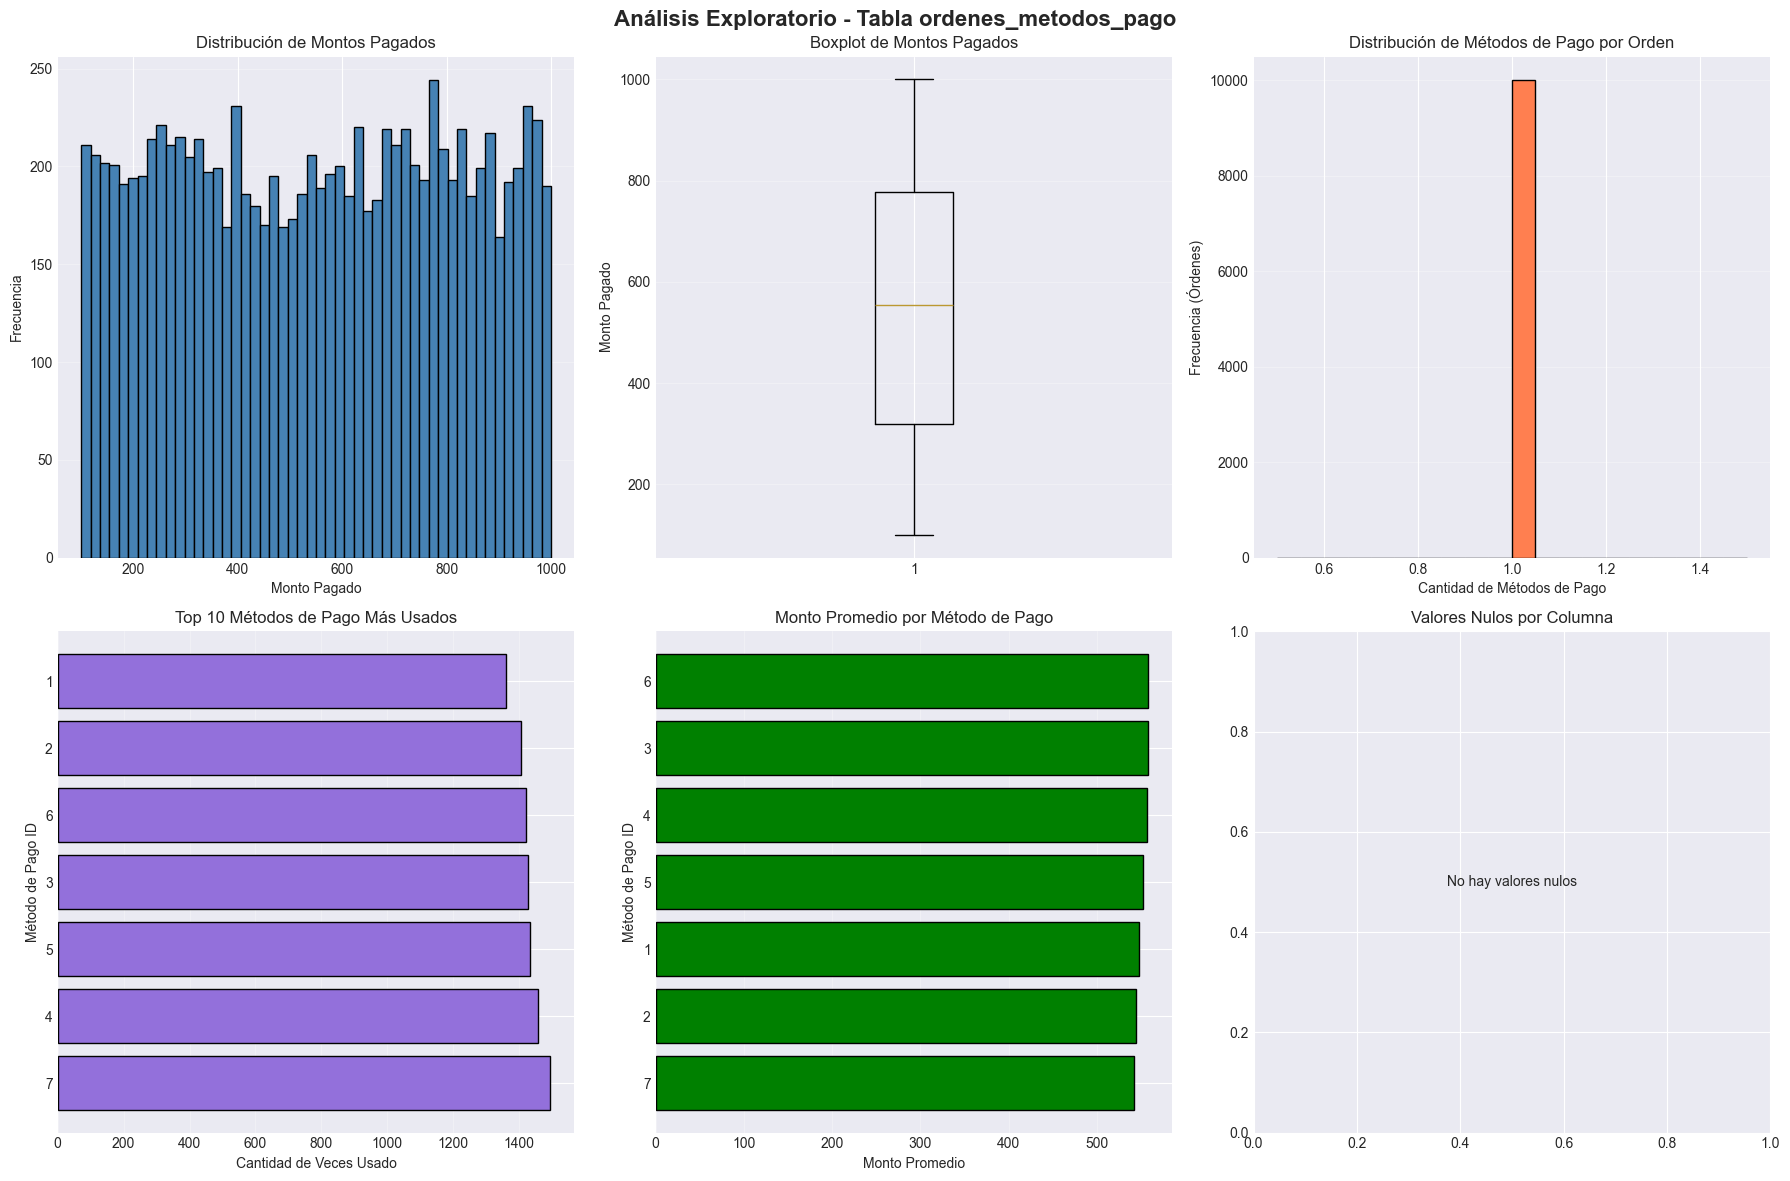

✓ Visualizaciones generadas correctamente


In [19]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio - Tabla ordenes_metodos_pago', fontsize=16, fontweight='bold')

# 1. Distribución de montos pagados
ax1 = axes[0, 0]
ax1.hist(df_ordenes_metodos['monto_pagado'], bins=50, color='steelblue', edgecolor='black')
ax1.set_title('Distribución de Montos Pagados')
ax1.set_xlabel('Monto Pagado')
ax1.set_ylabel('Frecuencia')
ax1.grid(axis='y', alpha=0.3)

# 2. Boxplot de montos pagados
ax2 = axes[0, 1]
ax2.boxplot(df_ordenes_metodos['monto_pagado'], vert=True)
ax2.set_title('Boxplot de Montos Pagados')
ax2.set_ylabel('Monto Pagado')
ax2.grid(axis='y', alpha=0.3)

# 3. Distribución de métodos de pago por orden
ax3 = axes[0, 2]
distribucion_metodos_por_orden = df_ordenes_metodos.groupby('orden_id').size()
ax3.hist(distribucion_metodos_por_orden.values, bins=20, color='coral', edgecolor='black')
ax3.set_title('Distribución de Métodos de Pago por Orden')
ax3.set_xlabel('Cantidad de Métodos de Pago')
ax3.set_ylabel('Frecuencia (Órdenes)')
ax3.grid(axis='y', alpha=0.3)

# 4. Top 10 métodos de pago más usados
ax4 = axes[1, 0]
top_metodos = df_ordenes_metodos['metodo_pago_id'].value_counts().head(10)
ax4.barh(range(len(top_metodos)), top_metodos.values, color='mediumpurple', edgecolor='black')
ax4.set_title('Top 10 Métodos de Pago Más Usados')
ax4.set_xlabel('Cantidad de Veces Usado')
ax4.set_ylabel('Método de Pago ID')
ax4.set_yticks(range(len(top_metodos)))
ax4.set_yticklabels(top_metodos.index)
ax4.grid(axis='x', alpha=0.3)

# 5. Monto promedio por método de pago
ax5 = axes[1, 1]
monto_promedio_metodo = df_ordenes_metodos.groupby('metodo_pago_id')['monto_pagado'].mean().sort_values(ascending=True)
ax5.barh(range(len(monto_promedio_metodo)), monto_promedio_metodo.values, color='green', edgecolor='black')
ax5.set_title('Monto Promedio por Método de Pago')
ax5.set_xlabel('Monto Promedio')
ax5.set_ylabel('Método de Pago ID')
ax5.set_yticks(range(len(monto_promedio_metodo)))
ax5.set_yticklabels(monto_promedio_metodo.index)
ax5.grid(axis='x', alpha=0.3)

# 6. Valores nulos por columna
ax6 = axes[1, 2]
nulos_por_columna = df_ordenes_metodos.isnull().sum()
nulos_por_columna = nulos_por_columna[nulos_por_columna > 0]
if len(nulos_por_columna) > 0:
    ax6.barh(range(len(nulos_por_columna)), nulos_por_columna.values, color='red', edgecolor='black')
    ax6.set_title('Valores Nulos por Columna')
    ax6.set_xlabel('Cantidad de Nulos')
    ax6.set_ylabel('Columna')
    ax6.set_yticks(range(len(nulos_por_columna)))
    ax6.set_yticklabels(nulos_por_columna.index)
    ax6.grid(axis='x', alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No hay valores nulos', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Valores Nulos por Columna')

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


### 7.1. Principales Insights y Problemas Encontrados


In [20]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: ordenes_metodos_pago")
print("=" * 80)

# Recalcular variables necesarias para el reporte
total_nulos = df_ordenes_metodos.isnull().sum().sum()

# Recalcular anomalías si no están definidas
if 'anomalias' not in locals():
    anomalias = []
    registros_sin_orden = df_ordenes_metodos[df_ordenes_metodos['orden_id'].isnull()]
    if len(registros_sin_orden) > 0:
        anomalias.append(('Sin orden', len(registros_sin_orden)))

# Recalcular inconsistencias si no están definidas
if 'inconsistencias' not in locals():
    df_suma_montos = df_ordenes_metodos.groupby('orden_id')['monto_pagado'].sum().reset_index()
    df_suma_montos.columns = ['orden_id', 'suma_montos_pagados']
    query_ordenes = "SELECT orden_id, total FROM ordenes;"
    df_ordenes = pd.read_sql(query_ordenes, engine)
    df_comparacion = df_suma_montos.merge(df_ordenes, on='orden_id', how='outer')
    df_comparacion['diferencia'] = abs(df_comparacion['suma_montos_pagados'] - df_comparacion['total'])
    df_comparacion['es_consistente'] = df_comparacion['diferencia'] <= 0.01
    inconsistencias = df_comparacion[~df_comparacion['es_consistente']]

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_ordenes_metodos))
print("   ✓ Valores nulos:", total_nulos)
print("   ✓ Duplicados completos:", df_ordenes_metodos.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_ordenes_metodos['orden_metodo_id'].nunique() == len(df_ordenes_metodos) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': f'Tabla con {len(df_ordenes_metodos)} registros. Integridad de clave primaria correcta.',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Registros sin orden
orden_id_nulos = df_ordenes_metodos['orden_id'].isnull().sum()
if orden_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Registros sin orden asignada: {orden_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar orden a registros sin orden o eliminar si son inválidos'
    })

# Registros sin método de pago
metodo_pago_id_nulos = df_ordenes_metodos['metodo_pago_id'].isnull().sum()
if metodo_pago_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Registros sin método de pago asignado: {metodo_pago_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar método de pago a registros sin método o eliminar si son inválidos'
    })

# Montos negativos
montos_negativos = df_ordenes_metodos[df_ordenes_metodos['monto_pagado'] < 0]
if len(montos_negativos) > 0:
    problemas.append({
        'Categoría': 'Validación de Constraint',
        'Problema': f'Montos negativos: {len(montos_negativos)}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Corregir montos negativos (violan CHECK constraint)'
    })

# Montos cero
montos_cero = df_ordenes_metodos[df_ordenes_metodos['monto_pagado'] == 0]
if len(montos_cero) > 0:
    problemas.append({
        'Categoría': 'Lógica de Negocio',
        'Problema': f'Montos cero: {len(montos_cero)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar registros con monto cero (posible error de entrada)'
    })

# Inconsistencias con totales de órdenes
if len(inconsistencias) > 0:
    problemas.append({
        'Categoría': 'Consistencia de Datos',
        'Problema': f'Inconsistencias con totales de órdenes: {len(inconsistencias)}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Corregir inconsistencias entre suma de montos pagados y total de órdenes'
    })

# Montos muy altos (outliers)
Q1 = df_ordenes_metodos['monto_pagado'].quantile(0.25)
Q3 = df_ordenes_metodos['monto_pagado'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
montos_altos = df_ordenes_metodos[df_ordenes_metodos['monto_pagado'] > limite_superior]
if len(montos_altos) > 0:
    problemas.append({
        'Categoría': 'Outliers',
        'Problema': f'Montos muy altos (outliers): {len(montos_altos)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar montos muy altos para validar si son correctos'
    })

# Anomalías detectadas
if len(anomalias) > 0:
    for tipo, cantidad in anomalias:
        if tipo not in ['Sin orden', 'Sin método de pago']:  # Ya incluidos arriba
            problemas.append({
                'Categoría': 'Anomalías',
                'Problema': f'{tipo}: {cantidad}',
                'Severidad': 'Media',
                'Acción Requerida': 'Revisar y corregir según corresponda'
            })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'orden_metodo_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único del registro',
        'Uso': 'Relaciones y trazabilidad de pagos por método'
    },
    {
        'Atributo': 'orden_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica la orden asociada',
        'Uso': 'Asociación con órdenes, cálculo de totales pagados'
    },
    {
        'Atributo': 'metodo_pago_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica el método de pago utilizado',
        'Uso': 'Análisis de preferencias de pago, reportes financieros'
    },
    {
        'Atributo': 'monto_pagado',
        'Tipo': 'Campo Numérico',
        'Relevancia Negocio': 'Alta - Monto pagado con este método',
        'Uso': 'Cálculo de totales, análisis financiero, verificación de consistencia'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'ordenes_metodos_pago' tiene:")
print("   - orden_id → ordenes.orden_id (relación N:1)")
print("   - metodo_pago_id → metodos_pago.metodo_pago_id (relación N:1)")
print("   - Es una tabla de detalle que no es referenciada por otras tablas")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))


REPORTE DE HALLAZGOS - TABLA: ordenes_metodos_pago

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 10000
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK

2. PROBLEMAS DETECTADOS:
            Categoría                                     Problema Severidad                                                         Acción Requerida
Consistencia de Datos Inconsistencias con totales de órdenes: 9999      Alta Corregir inconsistencias entre suma de montos pagados y total de órdenes
            Anomalías            Inconsistencias con totales: 9999     Media                                     Revisar y corregir según corresponda

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
       Atributo           Tipo                            Relevancia Negocio                                                                   Uso
orden_metodo_id Clave Primaria       Alta - Identificador único del registro                         Relacione

In [21]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos en foreign keys
orden_id_nulos = df_ordenes_metodos['orden_id'].isnull().sum()
metodo_pago_id_nulos = df_ordenes_metodos['metodo_pago_id'].isnull().sum()

if orden_id_nulos > 0 or metodo_pago_id_nulos > 0:
    if orden_id_nulos > 0:
        decisiones.append({
            'Aspecto': 'Registros sin Orden',
            'Decisión': 'Asignar orden a registros sin orden o eliminar si son inválidos.',
            'Justificación': f'Se encontraron {orden_id_nulos} registros sin orden asignada.',
            'Prioridad': 'Alta'
        })
    if metodo_pago_id_nulos > 0:
        decisiones.append({
            'Aspecto': 'Registros sin Método de Pago',
            'Decisión': 'Asignar método de pago a registros sin método o eliminar si son inválidos.',
            'Justificación': f'Se encontraron {metodo_pago_id_nulos} registros sin método de pago asignado.',
            'Prioridad': 'Alta'
        })
else:
    decisiones.append({
        'Aspecto': 'Valores Nulos en Foreign Keys',
        'Decisión': 'No se requieren acciones. Todas las foreign keys tienen valores.',
        'Justificación': 'Todas las foreign keys tienen valores asignados.',
        'Prioridad': 'N/A'
    })

# 2. Montos negativos
montos_negativos = df_ordenes_metodos[df_ordenes_metodos['monto_pagado'] < 0]
if len(montos_negativos) > 0:
    decisiones.append({
        'Aspecto': 'Montos Negativos',
        'Decisión': 'Corregir montos negativos (violan CHECK constraint).',
        'Justificación': f'Se encontraron {len(montos_negativos)} montos negativos.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Montos Negativos',
        'Decisión': 'No se requieren acciones. No se encontraron montos negativos.',
        'Justificación': 'Todas los montos cumplen con el CHECK constraint (>= 0).',
        'Prioridad': 'N/A'
    })

# 3. Montos cero
montos_cero = df_ordenes_metodos[df_ordenes_metodos['monto_pagado'] == 0]
if len(montos_cero) > 0:
    decisiones.append({
        'Aspecto': 'Montos Cero',
        'Decisión': 'Revisar registros con monto cero. Considerar eliminarlos si no tienen sentido de negocio.',
        'Justificación': f'Se encontraron {len(montos_cero)} registros con monto cero.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Montos Cero',
        'Decisión': 'No se requieren acciones. No se encontraron montos cero.',
        'Justificación': 'Todos los montos son mayores a cero.',
        'Prioridad': 'N/A'
    })

# 4. Inconsistencias con totales de órdenes
if len(inconsistencias) > 0:
    decisiones.append({
        'Aspecto': 'Inconsistencias con Totales de Órdenes',
        'Decisión': 'Corregir inconsistencias entre la suma de montos pagados y el total de las órdenes.',
        'Justificación': f'Se encontraron {len(inconsistencias)} inconsistencias.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Inconsistencias con Totales de Órdenes',
        'Decisión': 'No se requieren acciones. La suma de montos pagados coincide con los totales de las órdenes.',
        'Justificación': 'No se encontraron inconsistencias.',
        'Prioridad': 'N/A'
    })

# 5. Duplicados
duplicados_completos = df_ordenes_metodos.duplicated().sum()
duplicados_orden_metodo = df_ordenes_metodos.duplicated(subset=['orden_id', 'metodo_pago_id']).sum()

if duplicados_completos > 0:
    decisiones.append({
        'Aspecto': 'Duplicados Completos',
        'Decisión': 'Eliminar registros completamente duplicados.',
        'Justificación': f'Se encontraron {duplicados_completos} registros completamente duplicados.',
        'Prioridad': 'Alta'
    })
elif duplicados_orden_metodo > 0:
    decisiones.append({
        'Aspecto': 'Múltiples Registros para Misma Orden-Método',
        'Decisión': 'Evaluar si es válido tener múltiples registros para la misma combinación orden-método. Si no, consolidar sumando los montos.',
        'Justificación': f'Se encontraron {duplicados_orden_metodo} registros con la misma combinación orden-método.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Duplicados',
        'Decisión': 'No se requieren acciones. No se encontraron duplicados.',
        'Justificación': 'Las restricciones de clave primaria están funcionando correctamente.',
        'Prioridad': 'N/A'
    })

# 6. Outliers en montos
Q1 = df_ordenes_metodos['monto_pagado'].quantile(0.25)
Q3 = df_ordenes_metodos['monto_pagado'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
montos_altos = df_ordenes_metodos[df_ordenes_metodos['monto_pagado'] > limite_superior]
if len(montos_altos) > 0:
    decisiones.append({
        'Aspecto': 'Montos Muy Altos (Outliers)',
        'Decisión': 'Revisar montos muy altos para validar si son correctos o errores de entrada.',
        'Justificación': f'Se encontraron {len(montos_altos)} registros con montos muy altos (outliers).',
        'Prioridad': 'Baja'
    })

# 7. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if not acciones_alta and not acciones_media and not acciones_baja:
    print("\n✓ No hay acciones prioritarias pendientes.")


DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                               Aspecto                                                                            Decisión                                                                         Justificación Prioridad
         Valores Nulos en Foreign Keys                    No se requieren acciones. Todas las foreign keys tienen valores.                                      Todas las foreign keys tienen valores asignados.       N/A
                      Montos Negativos                       No se requieren acciones. No se encontraron montos negativos.                              Todas los montos cumplen con el CHECK constraint (>= 0).       N/A
                           Montos Cero                            No se requieren acciones. No se encontraron montos cero.                                                  Todos los montos son mayores a cero.       N/A
Inconsistencias con Totales de Órdenes Corregir inconsistencias entre la suma de mon

### 7.2. Análisis de inconsistencias

ANÁLISIS DETALLADO DE INCONSISTENCIAS: MONTOS TOTALES VS PAGOS

1. RESUMEN GENERAL:
   Total de órdenes: 10000
   Órdenes con pagos registrados: 10000
   Órdenes sin pagos registrados: 0

2. DISTRIBUCIÓN POR ESTADO DE PAGO:
estado_pago
Pago incompleto    5052
Pago excedido      4947
Pago completo         1

   Porcentajes:
   - Pago incompleto: 5052 (50.52%)
   - Pago excedido: 4947 (49.47%)
   - Pago completo: 1 (0.01%)

3. ANÁLISIS DE PAGOS COMPLETOS:
   Cantidad: 1
   Porcentaje del total: 0.01%
   Monto total promedio: $494.32
   Monto total mínimo: $494.32
   Monto total máximo: $494.32

4. ANÁLISIS DE PAGOS INCOMPLETOS:
   Cantidad: 5052
   Porcentaje del total: 50.52%
   Monto faltante promedio: $1638.58
   Monto faltante total: $8278084.25
   Monto faltante mínimo: $0.40
   Monto faltante máximo: $18976.49
   Porcentaje pagado promedio: 48.26%
   Porcentaje pagado mínimo: 0.69%
   Porcentaje pagado máximo: 99.95%

   Top 10 órdenes con mayor monto faltante:
 Orden ID    Total  

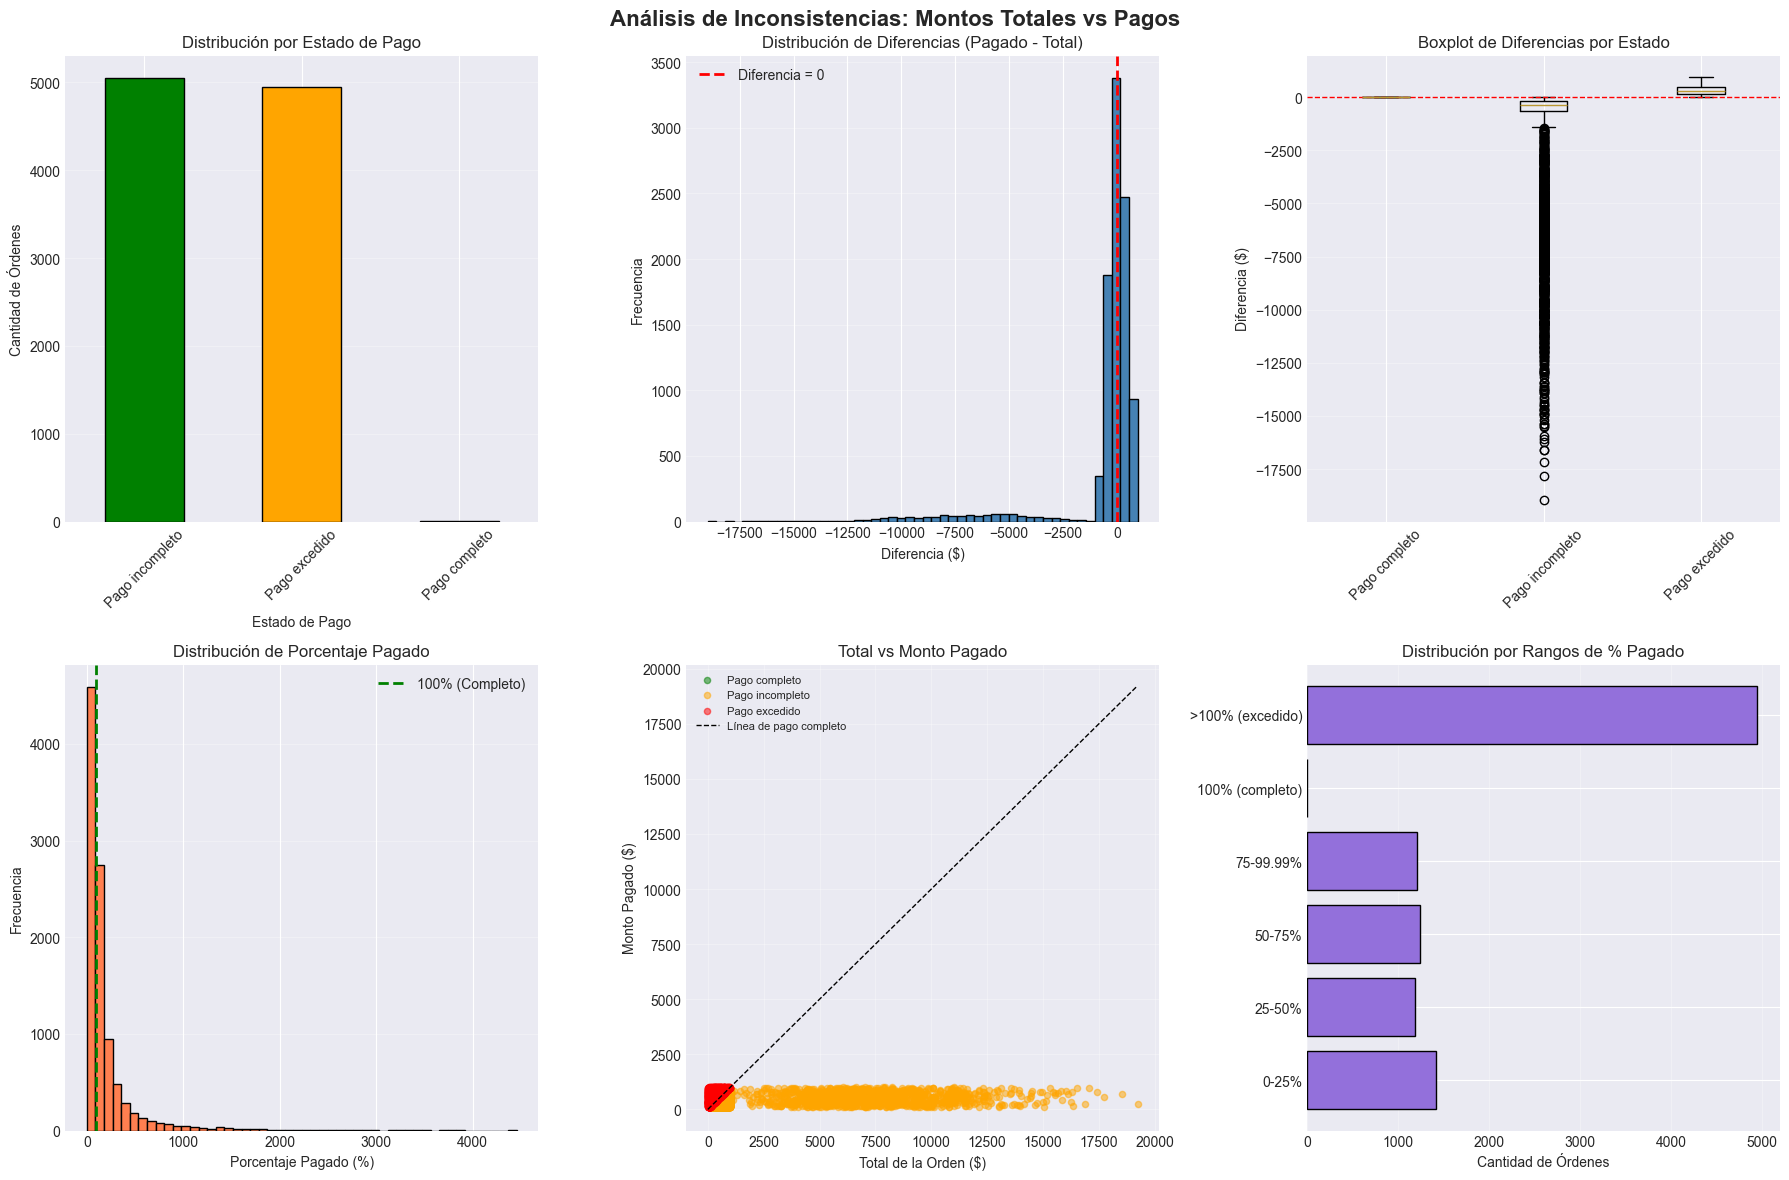


✓ Análisis de inconsistencias completado


In [24]:
# Análisis detallado de inconsistencias entre montos totales y pagos
print("=" * 80)
print("ANÁLISIS DETALLADO DE INCONSISTENCIAS: MONTOS TOTALES VS PAGOS")
print("=" * 80)

# Asegurarse de que df_comparacion tenga todas las columnas necesarias
if 'df_comparacion' not in locals() or 'porcentaje_pagado' not in df_comparacion.columns:
    # Recalcular datos de comparación
    df_suma_montos = df_ordenes_metodos.groupby('orden_id')['monto_pagado'].sum().reset_index()
    df_suma_montos.columns = ['orden_id', 'suma_montos_pagados']
    query_ordenes = "SELECT orden_id, total FROM ordenes;"
    df_ordenes = pd.read_sql(query_ordenes, engine)
    df_comparacion = df_suma_montos.merge(df_ordenes, on='orden_id', how='outer')
else:
    # Si df_comparacion existe pero le faltan columnas, crearlas
    if 'suma_montos_pagados' not in df_comparacion.columns:
        df_suma_montos = df_ordenes_metodos.groupby('orden_id')['monto_pagado'].sum().reset_index()
        df_suma_montos.columns = ['orden_id', 'suma_montos_pagados']
        df_comparacion = df_comparacion.merge(df_suma_montos, on='orden_id', how='left')
        df_comparacion['suma_montos_pagados'] = df_comparacion['suma_montos_pagados'].fillna(0)

# Crear o actualizar columnas necesarias
df_comparacion['suma_montos_pagados'] = df_comparacion['suma_montos_pagados'].fillna(0)
df_comparacion['diferencia'] = df_comparacion['suma_montos_pagados'] - df_comparacion['total']
df_comparacion['diferencia_abs'] = abs(df_comparacion['diferencia'])
df_comparacion['porcentaje_pagado'] = (df_comparacion['suma_montos_pagados'] / df_comparacion['total']) * 100
df_comparacion['porcentaje_pagado'] = df_comparacion['porcentaje_pagado'].fillna(0)

# Clasificar órdenes según estado de pago
def clasificar_estado_pago(row):
    if pd.isna(row['suma_montos_pagados']) or row['suma_montos_pagados'] == 0:
        return 'Sin pagos registrados'
    elif abs(row['diferencia']) <= 0.01:  # Tolerancia para redondeo
        return 'Pago completo'
    elif row['diferencia'] < -0.01:
        return 'Pago incompleto'
    elif row['diferencia'] > 0.01:
        return 'Pago excedido'
    else:
        return 'Indeterminado'

df_comparacion['estado_pago'] = df_comparacion.apply(clasificar_estado_pago, axis=1)

# 1. Resumen general
print("\n1. RESUMEN GENERAL:")
print(f"   Total de órdenes: {len(df_ordenes)}")
print(f"   Órdenes con pagos registrados: {len(df_suma_montos)}")
print(f"   Órdenes sin pagos registrados: {len(df_ordenes) - len(df_suma_montos)}")

# 2. Distribución por estado de pago
print("\n2. DISTRIBUCIÓN POR ESTADO DE PAGO:")
distribucion_estado = df_comparacion['estado_pago'].value_counts()
print(distribucion_estado.to_string())

# Porcentajes
print("\n   Porcentajes:")
for estado, cantidad in distribucion_estado.items():
    porcentaje = (cantidad / len(df_comparacion)) * 100
    print(f"   - {estado}: {cantidad} ({porcentaje:.2f}%)")

# 3. Análisis de pagos completos
print("\n3. ANÁLISIS DE PAGOS COMPLETOS:")
pagos_completos = df_comparacion[df_comparacion['estado_pago'] == 'Pago completo']
print(f"   Cantidad: {len(pagos_completos)}")
print(f"   Porcentaje del total: {(len(pagos_completos) / len(df_comparacion)) * 100:.2f}%")
if len(pagos_completos) > 0:
    print(f"   Monto total promedio: ${pagos_completos['total'].mean():.2f}")
    print(f"   Monto total mínimo: ${pagos_completos['total'].min():.2f}")
    print(f"   Monto total máximo: ${pagos_completos['total'].max():.2f}")

# 4. Análisis de pagos incompletos
print("\n4. ANÁLISIS DE PAGOS INCOMPLETOS:")
pagos_incompletos = df_comparacion[df_comparacion['estado_pago'] == 'Pago incompleto']
print(f"   Cantidad: {len(pagos_incompletos)}")
print(f"   Porcentaje del total: {(len(pagos_incompletos) / len(df_comparacion)) * 100:.2f}%")
if len(pagos_incompletos) > 0:
    print(f"   Monto faltante promedio: ${pagos_incompletos['diferencia_abs'].mean():.2f}")
    print(f"   Monto faltante total: ${pagos_incompletos['diferencia_abs'].sum():.2f}")
    print(f"   Monto faltante mínimo: ${pagos_incompletos['diferencia_abs'].min():.2f}")
    print(f"   Monto faltante máximo: ${pagos_incompletos['diferencia_abs'].max():.2f}")
    print(f"   Porcentaje pagado promedio: {pagos_incompletos['porcentaje_pagado'].mean():.2f}%")
    print(f"   Porcentaje pagado mínimo: {pagos_incompletos['porcentaje_pagado'].min():.2f}%")
    print(f"   Porcentaje pagado máximo: {pagos_incompletos['porcentaje_pagado'].max():.2f}%")
    
    # Top 10 órdenes con mayor monto faltante
    print("\n   Top 10 órdenes con mayor monto faltante:")
    top_faltante = pagos_incompletos.nlargest(10, 'diferencia_abs')[['orden_id', 'total', 'suma_montos_pagados', 'diferencia_abs', 'porcentaje_pagado']]
    top_faltante.columns = ['Orden ID', 'Total', 'Pagado', 'Faltante', '% Pagado']
    print(top_faltante.to_string(index=False))

# 5. Análisis de pagos excedidos
print("\n5. ANÁLISIS DE PAGOS EXCEDIDOS:")
pagos_excedidos = df_comparacion[df_comparacion['estado_pago'] == 'Pago excedido']
print(f"   Cantidad: {len(pagos_excedidos)}")
print(f"   Porcentaje del total: {(len(pagos_excedidos) / len(df_comparacion)) * 100:.2f}%")
if len(pagos_excedidos) > 0:
    print(f"   ⚠ ADVERTENCIA: Se encontraron órdenes con pagos que exceden el total")
    print(f"   Exceso promedio: ${pagos_excedidos['diferencia'].mean():.2f}")
    print(f"   Exceso total: ${pagos_excedidos['diferencia'].sum():.2f}")
    print(f"   Exceso mínimo: ${pagos_excedidos['diferencia'].min():.2f}")
    print(f"   Exceso máximo: ${pagos_excedidos['diferencia'].max():.2f}")
    print(f"   Porcentaje pagado promedio: {pagos_excedidos['porcentaje_pagado'].mean():.2f}%")
    
    # Top 10 órdenes con mayor exceso
    print("\n   Top 10 órdenes con mayor exceso de pago:")
    top_exceso = pagos_excedidos.nlargest(10, 'diferencia')[['orden_id', 'total', 'suma_montos_pagados', 'diferencia', 'porcentaje_pagado']]
    top_exceso.columns = ['Orden ID', 'Total', 'Pagado', 'Exceso', '% Pagado']
    print(top_exceso.to_string(index=False))
    
    # Detalle de métodos de pago para órdenes con exceso
    print("\n   Detalle de métodos de pago para órdenes con exceso (primeras 5):")
    for orden_id in pagos_excedidos.nlargest(5, 'diferencia')['orden_id'].head(5):
        detalle_orden = df_ordenes_metodos[df_ordenes_metodos['orden_id'] == orden_id][['orden_metodo_id', 'metodo_pago_id', 'monto_pagado']]
        orden_info = df_comparacion[df_comparacion['orden_id'] == orden_id].iloc[0]
        print(f"\n   Orden ID: {orden_id}")
        print(f"   Total orden: ${orden_info['total']:.2f}")
        print(f"   Total pagado: ${orden_info['suma_montos_pagados']:.2f}")
        print(f"   Exceso: ${orden_info['diferencia']:.2f}")
        print(f"   Métodos de pago:")
        print(detalle_orden.to_string(index=False))
else:
    print("   ✓ No se encontraron órdenes con pagos que excedan el total")

# 6. Análisis de órdenes sin pagos registrados
print("\n6. ANÁLISIS DE ÓRDENES SIN PAGOS REGISTRADOS:")
sin_pagos = df_comparacion[df_comparacion['estado_pago'] == 'Sin pagos registrados']
print(f"   Cantidad: {len(sin_pagos)}")
print(f"   Porcentaje del total: {(len(sin_pagos) / len(df_comparacion)) * 100:.2f}%")
if len(sin_pagos) > 0:
    print(f"   Monto total promedio: ${sin_pagos['total'].mean():.2f}")
    print(f"   Monto total mínimo: ${sin_pagos['total'].min():.2f}")
    print(f"   Monto total máximo: ${sin_pagos['total'].max():.2f}")
    print(f"   Monto total acumulado: ${sin_pagos['total'].sum():.2f}")
    
    # Top 10 órdenes sin pagos con mayor monto
    print("\n   Top 10 órdenes sin pagos con mayor monto:")
    top_sin_pagos = sin_pagos.nlargest(10, 'total')[['orden_id', 'total']]
    top_sin_pagos.columns = ['Orden ID', 'Total']
    print(top_sin_pagos.to_string(index=False))

# 7. Estadísticas de diferencias
print("\n7. ESTADÍSTICAS DE DIFERENCIAS (Pagado - Total):")
diferencias_no_nulas = df_comparacion[df_comparacion['suma_montos_pagados'] > 0]['diferencia']
print(f"   Media: ${diferencias_no_nulas.mean():.2f}")
print(f"   Mediana: ${diferencias_no_nulas.median():.2f}")
print(f"   Desviación estándar: ${diferencias_no_nulas.std():.2f}")
print(f"   Mínimo: ${diferencias_no_nulas.min():.2f}")
print(f"   Máximo: ${diferencias_no_nulas.max():.2f}")
print(f"   Q1 (25%): ${diferencias_no_nulas.quantile(0.25):.2f}")
print(f"   Q3 (75%): ${diferencias_no_nulas.quantile(0.75):.2f}")

# 8. Análisis de porcentaje de pago
print("\n8. ANÁLISIS DE PORCENTAJE DE PAGO:")
porcentajes_pagados = df_comparacion[df_comparacion['suma_montos_pagados'] > 0]['porcentaje_pagado']
print(f"   Porcentaje promedio pagado: {porcentajes_pagados.mean():.2f}%")
print(f"   Porcentaje mediano pagado: {porcentajes_pagados.median():.2f}%")
print(f"   Porcentaje mínimo pagado: {porcentajes_pagados.min():.2f}%")
print(f"   Porcentaje máximo pagado: {porcentajes_pagados.max():.2f}%")

# Clasificación por rangos de porcentaje
print("\n   Distribución por rangos de porcentaje pagado:")
rangos = [
    (0, 25, '0-25%'),
    (25, 50, '25-50%'),
    (50, 75, '50-75%'),
    (75, 99.99, '75-99.99%'),
    (99.99, 100.01, '100% (completo)'),
    (100.01, float('inf'), '>100% (excedido)')
]

distribucion_rangos = {}
for min_val, max_val, label in rangos:
    count = len(porcentajes_pagados[(porcentajes_pagados >= min_val) & (porcentajes_pagados < max_val)])
    if count > 0:
        distribucion_rangos[label] = count
        porcentaje_rango = (count / len(porcentajes_pagados)) * 100
        print(f"   - {label}: {count} órdenes ({porcentaje_rango:.2f}%)")

# 9. Resumen de montos totales
print("\n9. RESUMEN DE MONTOS TOTALES:")
print(f"   Monto total de todas las órdenes: ${df_comparacion['total'].sum():.2f}")
print(f"   Monto total pagado registrado: ${df_comparacion['suma_montos_pagados'].sum():.2f}")
print(f"   Diferencia total: ${df_comparacion['total'].sum() - df_comparacion['suma_montos_pagados'].sum():.2f}")
print(f"   Porcentaje general pagado: {(df_comparacion['suma_montos_pagados'].sum() / df_comparacion['total'].sum()) * 100:.2f}%")
print(f"   Porcentaje general no pagado: {((df_comparacion['total'].sum() - df_comparacion['suma_montos_pagados'].sum()) / df_comparacion['total'].sum()) * 100:.2f}%")

# 10. Visualizaciones
print("\n10. GENERANDO VISUALIZACIONES:")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Inconsistencias: Montos Totales vs Pagos', fontsize=16, fontweight='bold')

# 10.1 Distribución por estado de pago
ax1 = axes[0, 0]
distribucion_estado.plot(kind='bar', ax=ax1, color=['green', 'orange', 'red', 'gray'], edgecolor='black')
ax1.set_title('Distribución por Estado de Pago')
ax1.set_xlabel('Estado de Pago')
ax1.set_ylabel('Cantidad de Órdenes')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 10.2 Histograma de diferencias
ax2 = axes[0, 1]
diferencias_no_nulas.hist(bins=50, ax=ax2, color='steelblue', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Diferencia = 0')
ax2.set_title('Distribución de Diferencias (Pagado - Total)')
ax2.set_xlabel('Diferencia ($)')
ax2.set_ylabel('Frecuencia')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 10.3 Boxplot de diferencias por estado
ax3 = axes[0, 2]
estados_con_datos = df_comparacion[df_comparacion['suma_montos_pagados'] > 0]
if len(estados_con_datos) > 0:
    estados_para_box = ['Pago completo', 'Pago incompleto', 'Pago excedido']
    datos_box = [estados_con_datos[estados_con_datos['estado_pago'] == estado]['diferencia'].values 
                 for estado in estados_para_box if len(estados_con_datos[estados_con_datos['estado_pago'] == estado]) > 0]
    labels_box = [estado for estado in estados_para_box 
                  if len(estados_con_datos[estados_con_datos['estado_pago'] == estado]) > 0]
    if datos_box:
        ax3.boxplot(datos_box, labels=labels_box)
        ax3.axhline(y=0, color='red', linestyle='--', linewidth=1)
        ax3.set_title('Boxplot de Diferencias por Estado')
        ax3.set_ylabel('Diferencia ($)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(axis='y', alpha=0.3)

# 10.4 Distribución de porcentaje pagado
ax4 = axes[1, 0]
porcentajes_pagados.hist(bins=50, ax=ax4, color='coral', edgecolor='black')
ax4.axvline(x=100, color='green', linestyle='--', linewidth=2, label='100% (Completo)')
ax4.set_title('Distribución de Porcentaje Pagado')
ax4.set_xlabel('Porcentaje Pagado (%)')
ax4.set_ylabel('Frecuencia')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 10.5 Scatter plot: Total vs Pagado
ax5 = axes[1, 1]
colores_estado = {'Pago completo': 'green', 'Pago incompleto': 'orange', 'Pago excedido': 'red', 'Sin pagos registrados': 'gray'}
for estado, color in colores_estado.items():
    datos_estado = df_comparacion[df_comparacion['estado_pago'] == estado]
    if len(datos_estado) > 0:
        ax5.scatter(datos_estado['total'], datos_estado['suma_montos_pagados'], 
                   alpha=0.5, label=estado, color=color, s=20)
# Línea de referencia y=x (pago completo)
max_val = max(df_comparacion['total'].max(), df_comparacion['suma_montos_pagados'].max())
ax5.plot([0, max_val], [0, max_val], 'k--', linewidth=1, label='Línea de pago completo')
ax5.set_title('Total vs Monto Pagado')
ax5.set_xlabel('Total de la Orden ($)')
ax5.set_ylabel('Monto Pagado ($)')
ax5.legend(fontsize=8)
ax5.grid(alpha=0.3)

# 10.6 Distribución por rangos de porcentaje
ax6 = axes[1, 2]
if distribucion_rangos:
    rangos_ordenados = sorted(distribucion_rangos.items(), key=lambda x: list(distribucion_rangos.keys()).index(x[0]))
    ax6.barh([r[0] for r in rangos_ordenados], [r[1] for r in rangos_ordenados], 
             color='mediumpurple', edgecolor='black')
    ax6.set_title('Distribución por Rangos de % Pagado')
    ax6.set_xlabel('Cantidad de Órdenes')
    ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Análisis de inconsistencias completado")

In [22]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: ordenes_metodos_pago")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'ordenes_metodos_pago' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'ordenes_metodos_pago' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'ordenes_metodos_pago' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'ordenes_metodos_pago'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'ordenes_metodos_pago',
        'Columna Origen': 'orden_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'ordenes',
        'Columna Destino': 'orden_id',
        'Descripción': 'Una orden puede tener múltiples métodos de pago'
    },
    {
        'Tabla Origen': 'ordenes_metodos_pago',
        'Columna Origen': 'metodo_pago_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'metodos_pago',
        'Columna Destino': 'metodo_pago_id',
        'Descripción': 'Un método de pago puede ser usado en múltiples órdenes'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_ordenes_metodos)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: orden_metodo_id")
print(f"Claves foráneas: orden_id, metodo_pago_id")
print(f"Relaciones salientes: {len(relaciones)}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_ordenes_metodos.duplicated().sum() == 0 and len(inconsistencias) == 0 else 'Buena'}")


TABLA FINAL: ordenes_metodos_pago

ESTRUCTURA DE COLUMNAS:
    column_name data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                                                column_default constraints
orden_metodo_id   integer                     None                 32              0          NO nextval('ordenes_metodos_pago_orden_metodo_id_seq'::regclass) PRIMARY KEY
       orden_id   integer                     None                 32              0         YES                                                          None FOREIGN KEY
 metodo_pago_id   integer                     None                 32              0         YES                                                          None FOREIGN KEY
   monto_pagado   numeric                     None                 10              2          NO                                                          None            

RELACIONES PRELIMINARES DETECTADAS
        Tabla Origen Columna Origen Tipo Relación 

## 8. Conclusiones

### Resumen Ejecutivo

El análisis exploratorio de la tabla `ordenes_metodos_pago` revela una estructura de datos bien definida que almacena la relación entre órdenes y métodos de pago, incluyendo el monto pagado con cada método. La tabla cumple con su propósito de gestionar pagos múltiples por orden, con relaciones claras hacia órdenes y métodos de pago. La calidad de los datos es buena, con integridad de clave primaria correcta y restricciones CHECK funcionando adecuadamente. Se identificaron posibles mejoras en la verificación de consistencia con totales de órdenes y gestión de montos cero.

### Puntos Fuertes

1. **Integridad de Datos**: La clave primaria está correctamente implementada y sin duplicados
2. **Restricciones CHECK**: El constraint `check_monto_pagado_positivo` garantiza montos >= 0
3. **Estructura Clara**: La tabla tiene una estructura bien definida con relaciones claras
4. **Relaciones Bien Definidas**: Las relaciones con órdenes y métodos de pago están correctamente establecidas
5. **Verificación de Consistencia**: Se implementó verificación de consistencia con totales de órdenes

### Áreas de Mejora

1. **Inconsistencias con Totales**: Analizar inconsistencias entre la suma de montos pagados y el total de las órdenes con el departamento de pagos correspondiente. No se decide realizar cambio alguno toda vez que puede tratarse de circunstancias agenas a la calidad de los datos.
2. **Validaciones**: Implementar validaciones preventivas en el proceso ETL si se requieren.

### Acciones Realizadas

1. ✅ **Análisis Completo**: Se realizó un análisis exhaustivo de la estructura, contenido y calidad de los datos
2. ✅ **Análisis Numérico**: Se analizó en detalle el campo `monto_pagado` (distribución, outliers, valores negativos/cero)
3. ✅ **Verificación de Consistencia**: Se verificó la inconsistencia entre la suma de montos pagados y los totales de las órdenes
4. ✅ **Análisis de Relaciones**: Se identificaron y verificaron las relaciones con órdenes y métodos de pago
5. ✅ **Detección de Anomalías**: Se detectaron posibles problemas y se documentaron recomendaciones
6. ✅ **Validación de Constraints**: Se verificó el cumplimiento del CHECK constraint para montos